# Signal-to-noise calculations

Determining benefit of the narrow bandwidth filters over larger bandwidth.

The SNR is calculated following the equation (see, e.g., pg 407 of "Spectroscopic Instrumentation" by Eversberg and Vollmann): 

$SNR = \frac{I t}{\sqrt{I t + B t + D t + R^2}}$, 

where I is the signal over some number of pixels, B is the sky background over some number of pixels, D is the dark current over some number of pixels and R is the readout noise of the detector.  The exposure time, t, is usually given in seconds.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

In [2]:
def Dragonfly():
    number_of_lenses = 48.
    area_lens = np.pi*(14.3/2)**2 * number_of_lenses * u.cm**2               # 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                              # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    QE = 0.48     # quantum efficiency of the CCDs
    
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now

    # The following are per pixel
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    R_squared = 10.**2 * u.photon                           # read noise (electrons)

    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared]



### determining the sky background

#### Gemini Sky Background data  
(http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/skybg_50_10.dat)

sky background 0.3-1.0um

DARK optical sky - 50%ile conditions (day 7)

AM=1.0

derived from (reverse engineered ESO model) sky spectrum plus constant slope to match assumed photometric background (from von Hippel model.

#### UVES Sky Background data  
(http://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html)

In [5]:
def getBackgroundGemini(start,end,machine,plot=False):
    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    if machine=='chinook':
        geminiloc='/Users/lokhorst/Documents/Eagle/Gemini_skybackground.dat'
    elif machine=='coho':
        geminiloc='/Users/deblokhorst/Documents/Dragonfly/HalphaScripts/Gemini_skybackground.dat'
    
    with open(geminiloc,'r') as f:  #wavelength in nm, flux in phot/s/nm/arcsec^2/m^2
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    # for plottingn purposes:
    # wavelength[start_ind:end_ind],flux[start_ind:end_ind]
    
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
      #  print index,index+1
      #  print total
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    # if spacings are even, can just take the average of the flux array and times it by the total bandwidth
    np.mean(flux[start_ind:end_ind])*(wavelength[end_ind]-wavelength[start_ind])
    
   # print('start index and end index: %s and %s'%(start_ind,end_ind))
   # print(wavelength[start_ind:end_ind]-wavelength[start_ind+1:end_ind+1])
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total,wavelength[start_ind:end_ind],flux[start_ind:end_ind]

In [ ]:
def getBackgroundUVES(start,end,machine,plot=False):
    
    def getUVESBackground(filename):
        hdulist = fits.open(filename)
        flux = hdulist[0].data
    
        CRPIX1 = hdulist[0].header['CRPIX1']
        CRVAL1 = hdulist[0].header['CRVAL1']
        CDELT1 = hdulist[0].header['CDELT1']
        print(CRPIX1,CRVAL1,CDELT1)
        hdulist.close()
        
        begin = CRVAL1 - CRPIX1*CDELT1   
        end = begin + len(flux)*CDELT1
        wavelength = np.arange(begin,end,CDELT1)
        #print(len(wavelength),len(flux))
        return wavelength,flux

    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    filename1 = "fluxed_sky_580U.fits"
    filename2 = "fluxed_sky_860L.fits"


    if machine=='coho':
        uvesloc = '/Users/deblokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    elif machine =='chinook':
        uvesloc = '/Users/lokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    else:
        print 'No machine specified!'
    
    wavelength_UVES1,flux_UVES1=getUVESBackground(uvesloc+filename1)
    wavelength_UVES2,flux_UVES2=getUVESBackground(uvesloc+filename2)

    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    # for plottingn purposes:
    # wavelength[start_ind:end_ind],flux[start_ind:end_ind]
    
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
      #  print index,index+1
      #  print total
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    # if spacings are even, can just take the average of the flux array and times it by the total bandwidth
    np.mean(flux[start_ind:end_ind])*(wavelength[end_ind]-wavelength[start_ind])
    
   # print('start index and end index: %s and %s'%(start_ind,end_ind))
   # print(wavelength[start_ind:end_ind]-wavelength[start_ind+1:end_ind+1])
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total,wavelength[start_ind:end_ind],flux[start_ind:end_ind]

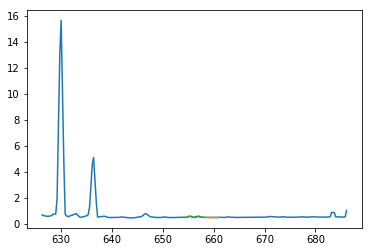

In [12]:
start = 656.3 - 30.
end = 656.3 + 30.
machine = 'chinook'
total,wavelen,flux = getBackgroundGemini(start,end,machine,plot=False)
plt.plot(wavelen,flux)


start = 659.9 - 1.5
end = 659.9 + 1.5
machine = 'chinook'
total,wavelen,flux = getBackgroundGemini(start,end,machine,plot=False)
plt.plot(wavelen,flux)

start = 656.3 - 1.5
end = 656.3 + 1.5
machine = 'chinook'
total,wavelen,flux = getBackgroundGemini(start,end,machine,plot=False)
plt.plot(wavelen,flux)